## 1. Data Selection & Preparation
**Dataset**: Pima Indians Diabetes (National Institute of Diabetes and Digestive and Kidney Diseases)  
**Link**: https://www.kaggle.com/uciml/pima-indians-diabetes-database  
**Rows**: 768, **Features**: 8, **Target**: Outcome (0 = non-diabetic, 1 = diabetic)

In [10]:
from pyspark.sql.functions import when, col
from pyspark.sql.types import DoubleType
from pyspark.sql import SparkSession
import os, sys

# -----------------------------------------------------------------
# Added this due to my own env issues
# Point both driver and workers - python executable:
os.environ["PYSPARK_PYTHON"]        = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

# Initialize Spark session
spark = (SparkSession
         .builder
         .appName("Diabetes Analysis")
         .config("spark.pyspark.python", sys.executable) # issues with my own env
         .config("spark.pyspark.driver.python", sys.executable) # issues with my own env
         .getOrCreate()
        )

# Load the dataset 
df = spark.read.csv('diabetes.csv', header=True, inferSchema=True)

# Columns that cannot be zero
zero_cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for c in zero_cols:
    mean_val = df.selectExpr(f"avg({c})").first()[0]
    df = df.withColumn(c, when(col(c)==0, mean_val).otherwise(col(c)))
    
# Cast types & show summary
df = df.select(*(col(c).cast(DoubleType()) for c in df.columns))
df.summary("count","mean","stddev","min","max").show()

+-------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------------+------------------+------------------+
|summary|       Pregnancies|           Glucose|     BloodPressure|     SkinThickness|           Insulin|              BMI|DiabetesPedigreeFunction|               Age|           Outcome|
+-------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------------+------------------+------------------+
|  count|               768|               768|               768|               768|               768|              768|                     768|               768|               768|
|   mean|3.8450520833333335|121.68160502115886| 72.25480651855469|26.606479220920118|118.66016303168442|32.45080515543617|      0.4718763020833327|33.240885416666664|0.3489583333333333|
| stddev|  3.36957806269887|30.436015643897118|12.115931598253848| 9.6

## 2. SparkSQL Exploration
- Compute average BMI by Outcome  
- Distribution of Age groups  

In [11]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Diabetes Analysis") \
    .getOrCreate()

df.createOrReplaceTempView("diabetes")
spark.catalog.cacheTable("diabetes")

# Average BMI per class
spark.sql("""
  SELECT Outcome,
         ROUND(AVG(BMI),1) AS avg_bmi,
         COUNT(*) AS count
  FROM diabetes
  GROUP BY Outcome
  ORDER BY avg_bmi DESC
""").show()

# Age distribution
spark.sql("""
  SELECT CASE 
           WHEN Age < 30 THEN '<30'
           WHEN Age BETWEEN 30 AND 50 THEN '30-50'
           ELSE '>50' 
         END AS age_group,
         COUNT(*) AS cnt
  FROM diabetes
  GROUP BY age_group
  ORDER BY age_group
""").show()


+-------+-------+-----+
|Outcome|avg_bmi|count|
+-------+-------+-----+
|    1.0|   35.4|  268|
|    0.0|   30.9|  500|
+-------+-------+-----+

+---------+---+
|age_group|cnt|
+---------+---+
|    30-50|291|
|      <30|396|
|      >50| 81|
+---------+---+



# 3.Machine-Learning Pipeline

1. Use a `Pipeline` to string together `VectorAssembler → StandardScaler → Classifier`.

2. Tune all four models via `ParamGridBuilder + CrossValidator`.

3. Compare on both AUC and accuracy.

In [12]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, VectorIndexer, PCA, ChiSqSelector, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define feature columns
feature_columns = [col for col in df.columns if col != "Outcome"]

# Split the dataset into training and testing datasets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Define stages
assembler = VectorAssembler(inputCols=feature_columns, outputCol="rawFeatures")
scaler    = StandardScaler(inputCol="rawFeatures", outputCol="features")  
selector  = ChiSqSelector(numTopFeatures=6, featuresCol="features", outputCol="selFeatures", labelCol="Outcome")
# Optionally add PCA
pca       = PCA(k=5, inputCol="selFeatures", outputCol="pcaFeatures")

# # Dict of classifiers
classifiers = {
  "LogisticRegression": LogisticRegression(featuresCol="pcaFeatures", labelCol="Outcome"),
  "RandomForest"      : RandomForestClassifier(featuresCol="pcaFeatures", labelCol="Outcome"),
  "GBT"               : GBTClassifier(featuresCol="pcaFeatures", labelCol="Outcome"),
  "DecisionTree"      : DecisionTreeClassifier(featuresCol="pcaFeatures", labelCol="Outcome")
}

# Define evaluators
evaluator = BinaryClassificationEvaluator(labelCol="Outcome", metricName="areaUnderROC")
acc_evaluator = MulticlassClassificationEvaluator(labelCol="Outcome", metricName="accuracy")

def train_and_eval(name, clf):
    # build a full pipeline for this classifier
    pipeline = Pipeline(stages=[assembler, scaler, selector, pca, clf])  # Using the existing assembler variable
    
    # construct a ParamGridBuilder and add only the relevant hyperparameters
    pg = ParamGridBuilder()
    if name == "LogisticRegression":
        pg = (pg
              .addGrid(clf.maxIter, [10, 20])
              .addGrid(clf.regParam, [0.0, 0.1])
             )
    else:
        # tree-based models share maxDepth
        pg = pg.addGrid(clf.maxDepth, [5, 10])
        # only RF and GBT have numTrees
        if hasattr(clf, "numTrees"):
            pg = pg.addGrid(clf.numTrees, [10, 20])
    paramGrid = pg.build()
    
    # set up 3-fold CV
    cv = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=evaluator,
        numFolds=3
    )
    
    # fit, predict, and evaluate
    cvModel = cv.fit(train_df)
    preds   = cvModel.transform(test_df)
    auc     = evaluator.evaluate(preds)
    acc     = acc_evaluator.evaluate(preds)
    
    print(f"{name}: AUC = {auc:.3f},  Accuracy = {acc:.3f}")

# run for each classifier
for name, clf in classifiers.items():
    train_and_eval(name, clf)


LogisticRegression: AUC = 0.855,  Accuracy = 0.789
RandomForest: AUC = 0.856,  Accuracy = 0.789
GBT: AUC = 0.833,  Accuracy = 0.772
DecisionTree: AUC = 0.753,  Accuracy = 0.748


# Advanced Data Visualization
- ROC curves for all models on one plot.

- Feature‐importance bar chart from RandomForest.

Exception ignored in: <function JavaModelWrapper.__del__ at 0x0000011D7D6D6980>
Traceback (most recent call last):
  File "c:\Users\Domenick Dobbs\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyspark\mllib\common.py", line 152, in __del__
    assert self._sc._gateway is not None
           ^^^^^^^^
AttributeError: 'BinaryClassificationMetrics' object has no attribute '_sc'


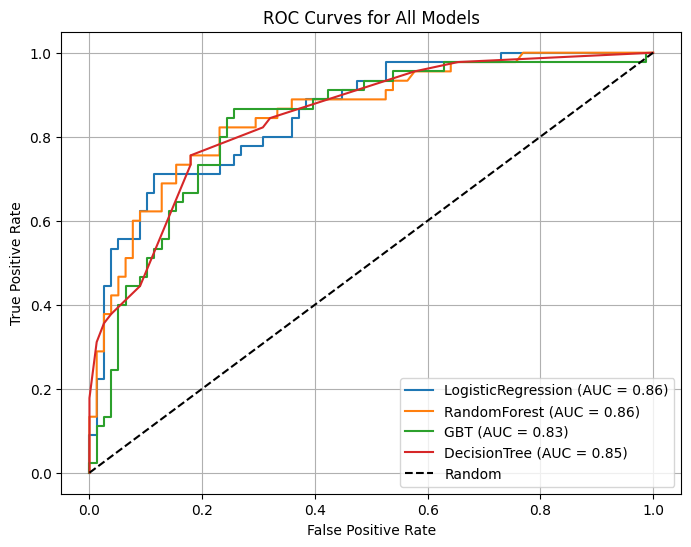

In [14]:
# you may need to pip install scikit-learn:
# !pip install scikit-learn

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

for name, clf in classifiers.items():
    # fit the pipeline
    pipeline = Pipeline(stages=[assembler, scaler, selector, pca, clf])
    model = pipeline.fit(train_df)
    
    # get probabilities & labels into Pandas on the driver
    pdf = (
        model
        .transform(test_df)
        .select("probability", "Outcome")
        .toPandas()
    )
    y_true  = pdf["Outcome"]
    y_score = pdf["probability"].apply(lambda arr: arr[1])
    
    # compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc     = auc(fpr, tpr)
    
    # plot
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# random baseline
plt.plot([0,1], [0,1], "k--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
